# Extra Diagnostics and Visualizations

This notebook requires `results_df.csv` (exported from the model optimization notebook) and `top20_features_xgb.csv` (feature rankings from XGBoost).  
Run each cell in order for a full set of diagnostic plots and summaries.  


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load results (produced by the main LSTM optimization notebook)
results_df = pd.read_csv("results_df.csv")

print(f"Loaded {results_df.shape[0]} sliding windows of results.")
results_df.head()


Loaded 23 sliding windows of results.


,window,accuracy,precision,recall,f1,roc_auc,sum_strategy_return,sum_market_return,mean_strategy_return,mean_market_return,comp_strategy_return,comp_market_return,sharpe_ratio,history
0,1,0.534660,0.524334,0.819942,0.639636,0.598683,28.449548,-4.564598,0.003800,-0.000610,6.065997e+10,-9.999022e-01,0.870439,"{'loss': [0.6378879547119141, 0.58531922101974..."
1,2,0.399760,0.544431,0.197890,0.290272,0.471605,-41.948981,53.214373,-0.005603,0.007108,-1.000000e+00,5.169430e+21,-1.553301,"{'loss': [0.6330732107162476, 0.58005183935165..."
2,3,0.433685,0.403279,0.696665,0.510844,0.464354,-57.788668,-112.514516,-0.007719,-0.015028,-1.000000e+00,-1.000000e+00,-0.989904,"{'loss': [0.635406494140625, 0.591704607009887..."
3,4,0.492988,0.596769,0.405628,0.482975,0.512247,-18.956407,86.030908,-0.002532,0.011491,-1.000000e+00,4.055800e+32,-0.351967,"{'loss': [0.6576350927352905, 0.61395484209060..."
4,5,0.548284,0.566757,0.802158,0.664218,0.531734,29.680302,37.594897,0.003964,0.005021,9.043212e+10,5.849552e+13,0.818959,"{'loss': [0.6487215757369995, 0.59623920917510..."


## Plotting Top 20 Features

We add a visualization from our Feature Engineering notebook.

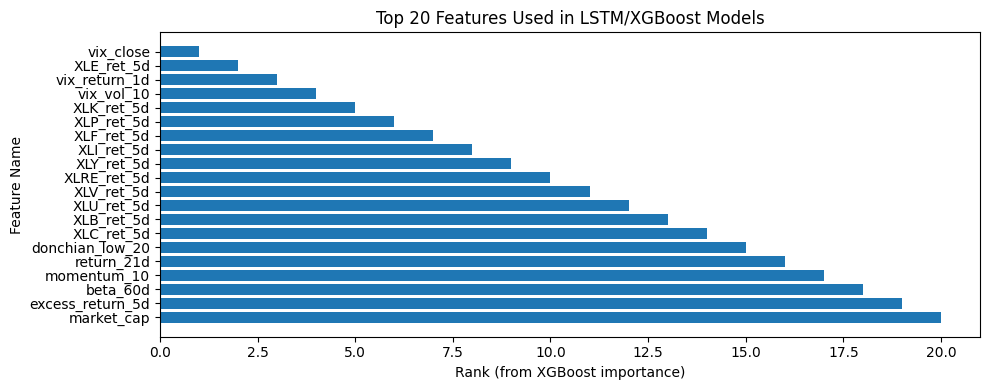

In [3]:
# Visualize top features if you have the CSV from the XGBoost run
try:
    feature_path = 'top20_features_xgb.csv'
    features = pd.read_csv(feature_path, skiprows=1, header=None)[0].tolist()

    plt.figure(figsize=(10,4))
    plt.barh(features[::-1], range(1, len(features)+1)[::-1])
    plt.title("Top 20 Features Used in LSTM/XGBoost Models")
    plt.xlabel("Rank (from XGBoost importance)")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not load or plot top20_features_xgb.csv:", e)
    print("If you want this plot, be sure to add top20_features_xgb.csv to your notebook directory.")


## Per-Window Performance Metrics

We visualize accuracy, F1 score, AUC, and Sharpe ratio for each sliding window to spot patterns or outlier periods.


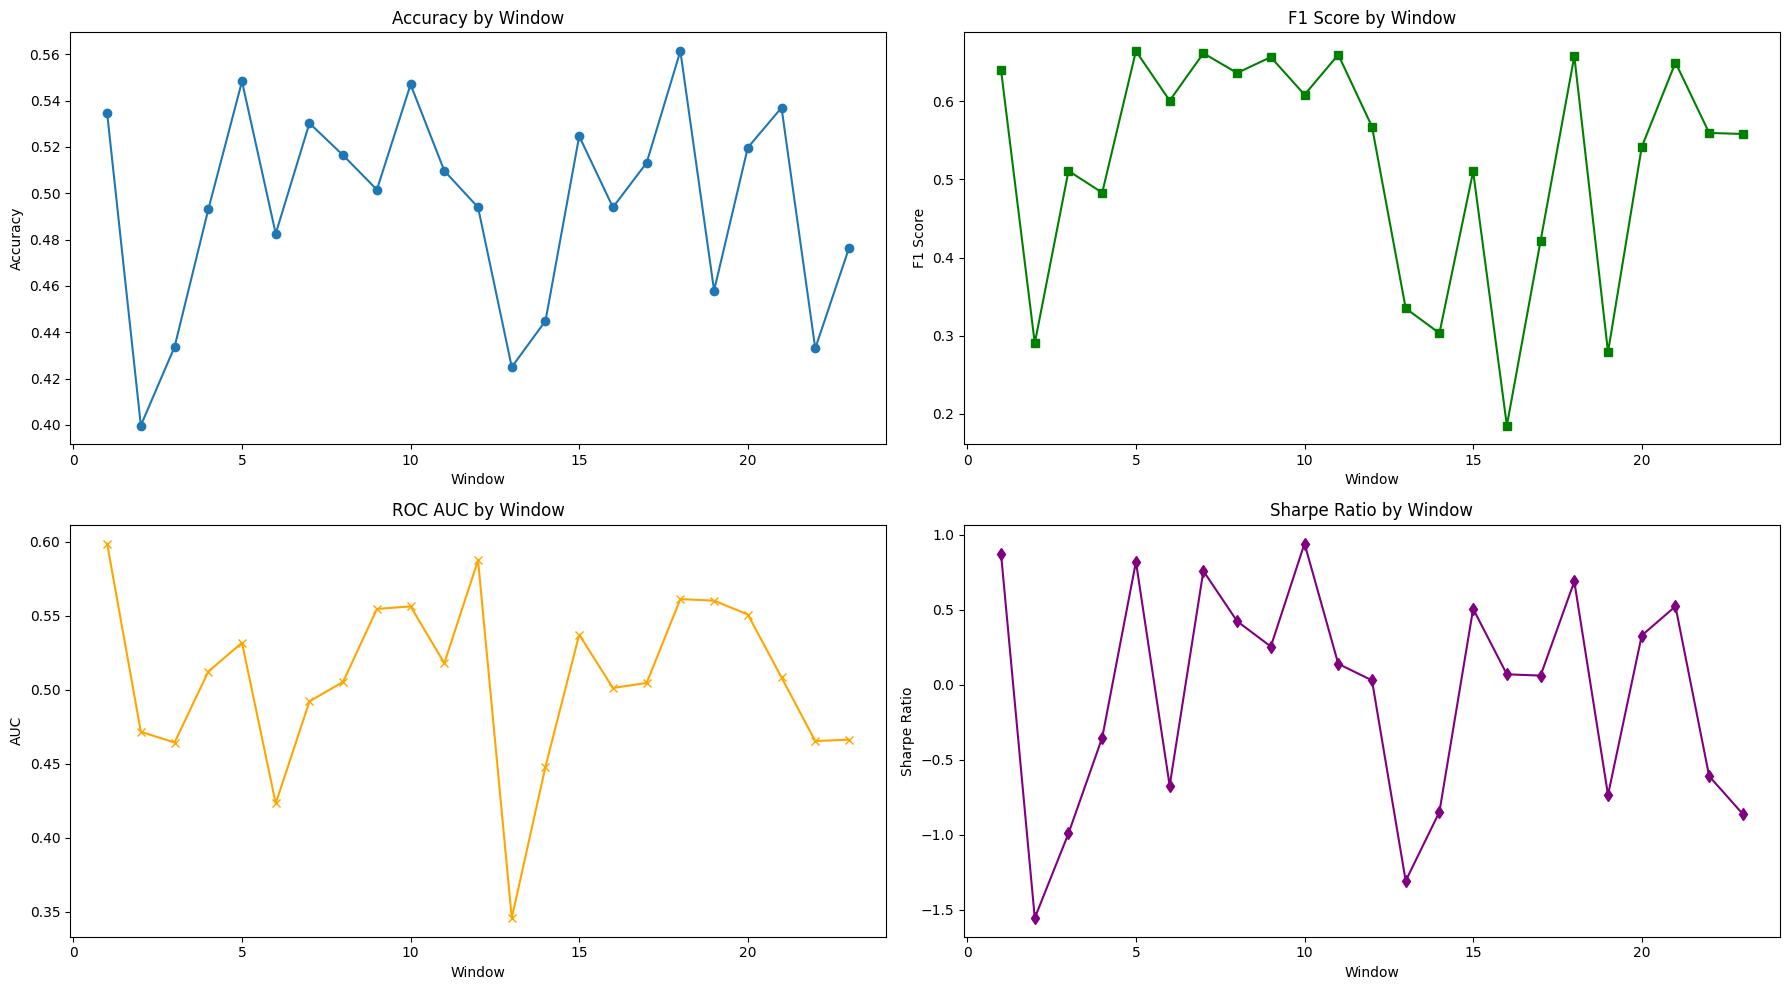

In [7]:
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.plot(results_df['window'], results_df['accuracy'], marker='o')
plt.title("Accuracy by Window")
plt.xlabel("Window")
plt.ylabel("Accuracy")

plt.subplot(2,2,2)
plt.plot(results_df['window'], results_df['f1'], marker='s', color='green')
plt.title("F1 Score by Window")
plt.xlabel("Window")
plt.ylabel("F1 Score")

plt.subplot(2,2,3)
plt.plot(results_df['window'], results_df['roc_auc'], marker='x', color='orange')
plt.title("ROC AUC by Window")
plt.xlabel("Window")
plt.ylabel("AUC")

plt.subplot(2,2,4)
plt.plot(results_df['window'], results_df['sharpe_ratio'], marker='d', color='purple')
plt.title("Sharpe Ratio by Window")
plt.xlabel("Window")
plt.ylabel("Sharpe Ratio")

plt.tight_layout()
plt.show()


## Outlier Detection

Highlighting sliding windows where the compounded strategy return or Sharpe ratio was extremely high or low.


In [8]:
# Detect outlier windows: Sharpe ratio less than -1.0 or compounded return -1.0 (hard stop)
outlier_windows = results_df[(results_df['sharpe_ratio'] < -1.0) | (results_df['comp_strategy_return'] <= -0.99)]

print("Detected", len(outlier_windows), "outlier windows based on Sharpe ratio or compounded return.")
print(outlier_windows[['window', 'sharpe_ratio', 'comp_strategy_return', 'accuracy', 'f1']])


Detected 10 outlier windows based on Sharpe ratio or compounded return.
    window  sharpe_ratio  comp_strategy_return  accuracy        f1
1        2     -1.553301             -1.000000  0.399760  0.290272
2        3     -0.989904             -1.000000  0.433685  0.510844
3        4     -0.351967             -1.000000  0.492988  0.482975
5        6     -0.672685             -1.000000  0.482570  0.600783
11      12      0.029525             -0.995668  0.493923  0.567515
12      13     -1.306161             -1.000000  0.425003  0.334930
13      14     -0.846698             -1.000000  0.444905  0.303152
18      19     -0.733781             -1.000000  0.457994  0.278962
21      22     -0.608891             -1.000000  0.433017  0.559419
22      23     -0.861631             -1.000000  0.476292  0.558098


## Example Training/Validation Loss Curve

For detailed diagnostics, we can visualize the training and validation loss for any window. The `results_df` DataFrame includes a stringified training history under the `history` column.


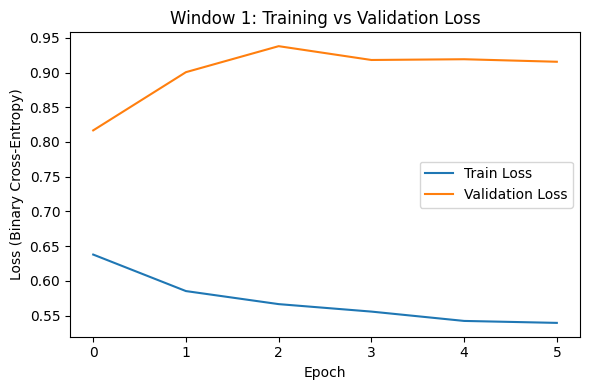

In [9]:
import ast

# The 'history' column contains stringified dicts; parse the loss arrays for the window of interest
win_idx = 0  # first window (can change as needed)
history_dict = ast.literal_eval(results_df.iloc[win_idx]['history'])

plt.figure(figsize=(6,4))
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title(f"Window {results_df.iloc[win_idx]['window']}: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Binary Cross-Entropy)")
plt.legend()
plt.tight_layout()
plt.show()


## Correlation Heatmap of Key Metrics

To understand how our main evaluation metrics interact, we can create a correlation heatmap. This allows us to see, for example, whether accuracy or F1 score actually move together with financial metrics like Sharpe ratio or compounded return. If they don’t, it’s a strong visual argument that accuracy alone isn’t enough in financial modeling.

Here’s a heatmap using our rolling window results.


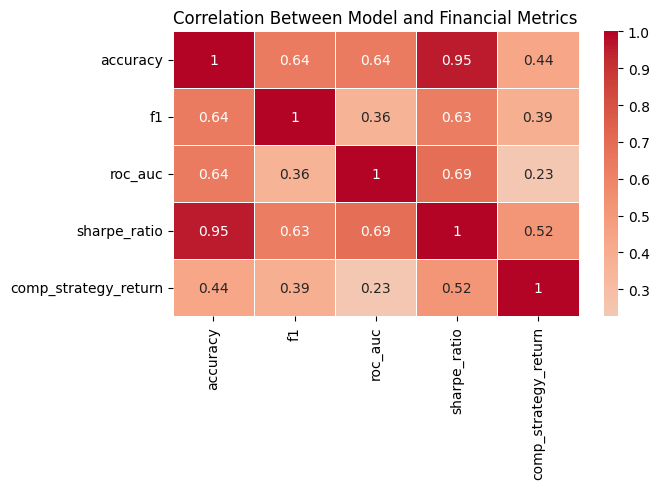

In [10]:
import seaborn as sns

# Select metrics of interest from your results_df
metrics_df = results_df[['accuracy', 'f1', 'roc_auc', 'sharpe_ratio', 'comp_strategy_return']]

# Compute correlation matrix
corr = metrics_df.corr()

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Between Model and Financial Metrics")
plt.tight_layout()
plt.show()


## Diagnostics and Performance Visualization Summary

- The additional visualizations in this notebook provide a clear, window-by-window view of our model's strengths and weaknesses. Outlier windows, especially Windows 2 and 13, had sharply negative Sharpe ratios and compounded returns. These were directly linked to below-baseline accuracy and F1 scores for those periods. Overall, accuracy across all windows stayed just above random chance. Both risk-adjusted performance (Sharpe) and class separation (AUC) varied widely by window.

- The correlation heatmap between model metrics and financial performance provides additional insight. Accuracy and F1 are both strongly correlated with Sharpe ratio, suggesting that periods with higher classification performance do line up with improved risk-adjusted returns. However, compounded strategy return is only weakly correlated with all other metrics, confirming that even when the model gets direction right more often, actual trading profits can be highly unstable. This supports our broader conclusion that standard ML metrics alone do not guarantee meaningful financial performance in short-term trading.

- The loss curve plots for selected windows show that early stopping and adaptive learning rates were effective in preventing overfitting. Even so, the model's ability to improve further after the first few epochs was limited, which highlights the challenge of short-term stock prediction.

- These insights confirm the main finding of the project. The LSTM model, even after extensive tuning and cross-validation, found only a weak and unstable edge in the chosen features. While this is informative from an academic perspective, it is not strong enough for use in a production trading environment without significant improvements and stronger risk controls.
